In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import string
import os

from capt_gen import capt_decode
from capt_gen import height, width, n_len

In [2]:
def _read_example(filename_queue):
    
    class _Record(object):
        pass
    result = _Record()
    
    result.height = height
    result.width = width
    result.depth = 3
    
    reader = tf.TFRecordReader()
    result.key, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
        serialized_example,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.string)
        }
    )

    image = tf.image.decode_png(features['image'])
    result.uint8image = tf.reshape(image, [result.height, result.width, result.depth])
    label = tf.decode_raw(features['label'], tf.uint8)
    result.label = tf.cast(label, tf.int64)
    return result


def _get_batch(image, label, min_queue_examples, batch_size):
    num_preprocess_threads = 16
    
    images, labels = tf.train.shuffle_batch(
        [image, label], 
        batch_size = batch_size, 
        num_threads = num_preprocess_threads, 
        capacity = min_queue_examples + 3*batch_size, 
        min_after_dequeue=min_queue_examples
    )
    
    tf.summary.image('images', images)
    return images, tf.reshape(labels, [batch_size, n_len])

In [3]:
def inputs(data_dir, batch_size=64):
    path = os.path.join(data_dir, '*/*.tfrecords')
    filename_queue = tf.train.string_input_producer(tf.train.match_filenames_once(path))
    
    with tf.variable_scope('preprocessing'):
        example = _read_example(filename_queue)
        image, label = example.uint8image, example.label
        std_image = tf.image.per_image_standardization(image)
        
        std_image.set_shape([example.height, example.width, example.depth])
        label.set_shape([n_len])
        
        min_fraction_of_examples_in_queue = .004
        num_examples_per_epoch = 400000
        min_queue_examples = int(num_examples_per_epoch * min_fraction_of_examples_in_queue)
        print('Filling queue with %d captcha images before starting to train. '
             'This will take a few minutes' % min_queue_examples)
        
    return _get_batch(std_image, label, min_queue_examples, batch_size)

Filling queue with 1600 captcha images before starting to train. This will take a few minutes


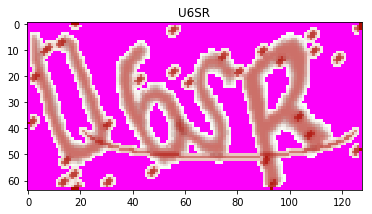

In [4]:
if __name__ == '__main__':    
    images, labels = inputs('./tfrecords')
    image, label = images[0], labels[0]
    min_, max_ = tf.reduce_min(image), tf.reduce_max(image)
    image = tf.cast((image - min_)/(max_ - min_)*256, tf.uint8)
    
    sess = tf.Session()

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    a, b = sess.run([image, label])
    plt.imshow(a)
    plt.title(capt_decode(b))
    plt.show()